In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from sklearn.metrics import classification_report , confusion_matrix
from skimage import exposure
import numpy as np

In [49]:
image_folder = r"C:\Users\tyhoo\Documents\python project\PROJECT\BREAST_CANCER_IMAGE_CNN\output"
img_width, img_height = 460, 460
batch_size = 16

In [50]:
 # 設定圖片尺寸與批次大小
def image_enhance(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image,size=[img_width, img_height,3])
    image = tf.image.per_image_standardization(image)
    image = tf.image.adjust_contrast(image,2)
    return image

def image_process(image):
    image = tf.image.per_image_standardization(image)
    image = tf.image.adjust_contrast(image,2)
    return image

def load_pic(image_folder,img_width,img_height,batch_size):
    # 建立 ImageDataGenerator 物件
    datagen_train = ImageDataGenerator(rescale=1.0/255.0,preprocessing_function=image_enhance)
    datagen_test_val = ImageDataGenerator(rescale=1.0/255.0,preprocessing_function=image_process)
    # 使用 ImageDataGenerator 從資料夾中載入訓練集和測試集
    train_generator = datagen_train.flow_from_directory(
        os.path.join(image_folder,'train'),
        target_size= (img_width,img_height),
        batch_size= batch_size,
        class_mode='categorical',
        shuffle=True)
    test_generator = datagen_test_val.flow_from_directory(
        os.path.join(image_folder,'test'),
        target_size= (428,img_height),
        batch_size= batch_size,
        class_mode='categorical',
        shuffle=False)
    validation_generator = datagen_test_val.flow_from_directory(
        os.path.join(image_folder,'val'),
        target_size= (img_width,img_height),
        batch_size= batch_size,
        class_mode='categorical',
        shuffle=False)
    print('Data generators ready')
    return train_generator,test_generator,validation_generator


In [51]:
train_generator,test_generator,validation_generator  = load_pic(image_folder,img_width, img_height,batch_size)

Found 7696 images belonging to 2 classes.
Found 1028 images belonging to 2 classes.
Found 1538 images belonging to 2 classes.
Data generators ready


In [52]:
#導入resnet
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [53]:
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

#超參設置
callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0,
            patience=10, verbose=0, mode='min',
            baseline=None, restore_best_weights=True)
#設定epoch
epoch = 30

# 優化器
optimizers = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# 學習率調度器
lr_schedule = ExponentialDecay(initial_learning_rate=0.1, decay_steps=7, decay_rate=0.1)
optimizer_with_scheduler = tf.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# 模型編譯
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
history = model.fit(train_generator,
                    epochs = epoch, 
                    validation_data=validation_generator,
                    callbacks=callback
                   )

Epoch 1/30
481/481 [==============================] - 332s 683ms/step - loss: 0.3072 - accuracy: 0.8699 - val_loss: 0.8712 - val_accuracy: 0.5169
Epoch 2/30
481/481 [==============================] - 342s 711ms/step - loss: 0.1768 - accuracy: 0.9333 - val_loss: 0.3661 - val_accuracy: 0.8869
Epoch 3/30
481/481 [==============================] - 343s 713ms/step - loss: 0.1393 - accuracy: 0.9485 - val_loss: 0.1941 - val_accuracy: 0.9174
Epoch 4/30
481/481 [==============================] - 341s 708ms/step - loss: 0.1020 - accuracy: 0.9630 - val_loss: 0.1974 - val_accuracy: 0.9363
Epoch 5/30
481/481 [==============================] - 334s 694ms/step - loss: 0.0914 - accuracy: 0.9660 - val_loss: 0.1431 - val_accuracy: 0.9428
Epoch 6/30
481/481 [==============================] - 333s 692ms/step - loss: 0.0694 - accuracy: 0.9747 - val_loss: 0.1225 - val_accuracy: 0.9558
Epoch 7/30
481/481 [==============================] - 341s 709ms/step - loss: 0.0532 - accuracy: 0.9800 - val_loss: 0.0469 -

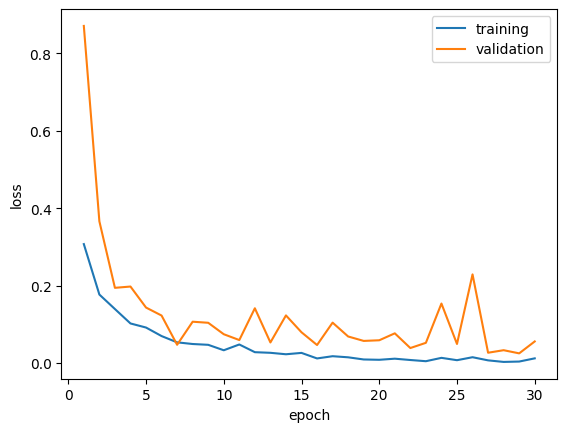

In [55]:
#繪製loss圖

epochs = epoch
from matplotlib import pyplot as plt
epoch_nums = range(1,epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


In [56]:
#報告
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_generator.classes
class_report =  classification_report(y_test,y_pred)
matrix = confusion_matrix(y_test,y_pred)
print(class_report)
print(matrix)

65/65 [==============================] - 21s 315ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       497
           1       0.99      0.96      0.98       531

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028

[[493   4]
 [ 21 510]]


In [57]:
from tensorflow import keras
model.save('Resnet50_BC_Image')

INFO:tensorflow:Assets written to: Resnet50_BC_Image\assets


INFO:tensorflow:Assets written to: Resnet50_BC_Image\assets
